Task 2 - Predict Customer Buying Behaviour

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore") 

In [5]:
data="customer_booking.csv"

In [6]:
import chardet

with open("customer_booking.csv","rb") as rawdata:
  result=chardet.detect(rawdata.read(100000))
print(result)
     

{'encoding': 'ISO-8859-1', 'confidence': 0.73, 'language': ''}


In [7]:
df=pd.read_csv(data,encoding="ISO-8859-1")

In [8]:
df.head()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,2,Internet,RoundTrip,262,19,7,Sat,AKLDEL,New Zealand,1,0,0,5.52,0
1,1,Internet,RoundTrip,112,20,3,Sat,AKLDEL,New Zealand,0,0,0,5.52,0
2,2,Internet,RoundTrip,243,22,17,Wed,AKLDEL,India,1,1,0,5.52,0
3,1,Internet,RoundTrip,96,31,4,Sat,AKLDEL,New Zealand,0,0,1,5.52,0
4,2,Internet,RoundTrip,68,22,15,Wed,AKLDEL,India,1,0,1,5.52,0


Exploratory Data Analysis

In [10]:
#checking for datatypes
df.dtypes

num_passengers             int64
sales_channel             object
trip_type                 object
purchase_lead              int64
length_of_stay             int64
flight_hour                int64
flight_day                object
route                     object
booking_origin            object
wants_extra_baggage        int64
wants_preferred_seat       int64
wants_in_flight_meals      int64
flight_duration          float64
booking_complete           int64
dtype: object

In [12]:
#shape of dataset
df.shape

(50000, 14)

In [13]:
#null values
df.isnull().sum()

num_passengers           0
sales_channel            0
trip_type                0
purchase_lead            0
length_of_stay           0
flight_hour              0
flight_day               0
route                    0
booking_origin           0
wants_extra_baggage      0
wants_preferred_seat     0
wants_in_flight_meals    0
flight_duration          0
booking_complete         0
dtype: int64

In [14]:
df.booking_complete.value_counts()

booking_complete
0    42522
1     7478
Name: count, dtype: int64

Mutual Information

In [17]:
X= df.drop('booking_complete',axis=1)
y= df.booking_complete         

#changing object dtype to int dtype
for colname in X.select_dtypes("object"):
    X[colname],_=X[colname].factorize()

In [18]:
X.dtypes

num_passengers             int64
sales_channel              int64
trip_type                  int64
purchase_lead              int64
length_of_stay             int64
flight_hour                int64
flight_day                 int64
route                      int64
booking_origin             int64
wants_extra_baggage        int64
wants_preferred_seat       int64
wants_in_flight_meals      int64
flight_duration          float64
dtype: object

In [19]:
from sklearn.feature_selection import mutual_info_classif

mi_scores=mutual_info_classif(X,y)
mi_scores=pd.Series(mi_scores,name="MI Scores",index=X.columns)
mi_scores=mi_scores.sort_values(ascending=False)
mi_scores # show a few features with their MI scores

route                    0.051988
booking_origin           0.045826
flight_duration          0.019511
wants_extra_baggage      0.010262
length_of_stay           0.008037
wants_in_flight_meals    0.004207
flight_hour              0.003618
trip_type                0.002264
wants_preferred_seat     0.002251
sales_channel            0.000673
flight_day               0.000252
purchase_lead            0.000192
num_passengers           0.000098
Name: MI Scores, dtype: float64

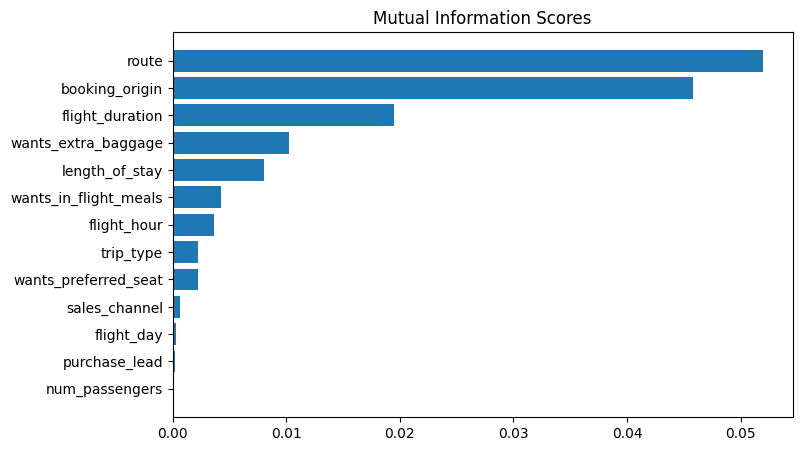

In [20]:
def plot_mi_scores(scores):
    scores=scores.sort_values(ascending=True)
    width=np.arange(len(scores))
    ticks=list(scores.index)
    plt.barh(width,scores)
    plt.yticks(width,ticks)
    plt.title("Mutual Information Scores")
plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores)

We can see that


1)route

2)booking_origin

3)flight_duration

4)wants_extra_baggage

5)length_of_stay

are the top 5 features which are dependant with booking_complete feature

In [23]:
#test train split

from sklearn.model_selection import train_test_split

# dataset split
# creating a function for dataset split
def dataset(X,y):
    train_full_X,val_X,train_full_y,val_y=train_test_split(X,y,test_size=0.2,random_state=0)

# Use the same function above for the validation set
    train_X, test_X, train_y, test_y = train_test_split(train_full_X,train_full_y,test_size=0.25,random_state=0)
    return (train_X,val_X,train_y,val_y)

In [24]:
from sklearn.preprocessing import MinMaxScaler

def scale(X):
    scaler=MinMaxScaler()
    scaler.fit(X)
    return X

Random Forest Classifier Model

In [29]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
X= df.drop("booking_complete",axis=1)
#one hot encoding
X=pd.get_dummies(X)
X=scale(X)
y=df.booking_complete       

X_train,X_val,y_train,y_val=dataset(X,y)

forest_model= RandomForestClassifier(random_state=1)
forest_model.fit(X_train,y_train)
preds= forest_model.predict(X_val)

print("ACCURACY: ",accuracy_score(y_val,preds)*100)
print("AUC score: ",roc_auc_score(y_val,preds))

ACCURACY:  84.76
AUC score:  0.5479604084813514


Validating with Test Data Set

In [32]:
X= df.drop("booking_complete",axis=1)
#one hot encoding
X=pd.get_dummies(X)
X=scale(X)
y=df.booking_complete       

train_full_X,test_X,train_full_y,test_y=train_test_split(X,y,test_size=0.2,random_state=0)

forest_model=RandomForestClassifier(random_state=1)
forest_model.fit(train_full_X, train_full_y)
preds= forest_model.predict(test_X)

print("ACCURACY: ",accuracy_score(test_y,preds)*100)
print("AUC score: ",roc_auc_score(test_y,preds))

ACCURACY:  85.09
AUC score:  0.5577796717361984
